# Interlocking International Networks from the *Panama Papers*
# The Case of Greece, Cyprus and Russia
## By Moses Boudourides & Sergios Lenis 

In [25]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## 1. Basic Structure of the *Panama Papers* Dataset

* The Panama Paper dataset (downloadable from https://offshoreleaks.icij.org/pages/database) consists of five separate data matrices:
    1. The data matrix of **edges** containing 1265690 rows and 3 columns. 
        * The second column (named 'rel_type') corresponds to the **type of relation** that binds the node of the first column (called 'node_1') with the node of the third column (called 'node_2'). Each one of the two nodes is identified by a certain number called **node id**.
        * There are five types of relations (directed edges):
            1. node 1 being **officer of** node 2.
            2. node 1 being **intermediary of** node 2.
            3. node 2 being **registered address of** node 2.
            4. node 3 being **similar to** node 2.
            5. node 4 being **underlying to** node 2.
    2. The data matrix of **officers** containing 345594 rows and 7 columns. 
    3. The data matrix of **intermediaries** 23636 rows and 9 columns. 
    4. The data matrix of **(offshore) entities** containing 319150 rows and 21 columns. 
    5. The data matrix of **addresses** containing 151054 rows and 7 columns. 
* Among all the columns of the last four data matrices, here, we are going to focus on three columns:
    * **node_id**, **countries** and **country codes** appearing in all four data matrices.
    * **name** appearing in the first three data matrices (i.e., all of them except "addresses").
* Thus, we can merge the four data matrices ("officers", "intermediaries", "entities" and "addresses") together in such a way that they are indexed by the (unique) node_id. 
    * The merged dataset will be called **all-nodes dataframe**.
    * Each row of this dataframe will be called **node**.
    * A new column (called **type**) is added in order to indicate whether a node is an officer or an intermediary or an entity or an address.
    * In particular, the all-nodes dataframe contains 
        * 839434 rows (nodes) and 23 columns,
        * 838295 unique node_ids,
        * 345594 officers,
        * 23636 intermediaries,
        * 319150 (offshore) entities,
        * 151054 addresses and
        * 209 countries.

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas.tools.plotting import scatter_matrix
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import math
import random
import os
from lightning import Lightning

edges = pd.read_csv('offshore_leaks_csvs-20160621/all_edges.csv')
rels = edges.rel_type.unique()
edges_officer_of = edges.loc[edges['rel_type']=='officer_of']
edges_intermediary_of = edges.loc[edges['rel_type']=='intermediary_of']
edges_registered_address = edges.loc[edges['rel_type']=='registered_address']
edges_similar = edges.loc[edges['rel_type']=='similar']
edges_underlying = edges.loc[edges['rel_type']=='underlying']
Officers = pd.read_csv('offshore_leaks_csvs-20160621/Officers.csv')
Intermediaries = pd.read_csv('offshore_leaks_csvs-20160621/Intermediaries.csv')
Entities = pd.read_csv('offshore_leaks_csvs-20160621/Entities.csv')
Addresses = pd.read_csv('offshore_leaks_csvs-20160621/Addresses.csv')
print 'The data matrix "edges" contains %i rows and %i columns' %(edges.shape[0],edges.shape[1])
print 'The', edges.shape[1], 'columns of the data matrix "edges" are', list(edges.columns)
print 'The types of relations are', list(rels)
print "The number of edges of type 'officer_of' are", edges_officer_of.shape[0]
print "The number of edges of type 'intermediary_of' are", edges_intermediary_of.shape[0]
print "The number of edges of type 'registered_address' are", edges_registered_address.shape[0]
print "The number of edges of type 'similar' are", edges_similar.shape[0]
print "The number of edges of type 'underlying' are", edges_underlying.shape[0]
print
print 'The data matrix "officers" contains %i rows and %i columns' %(Officers.shape[0],Officers.shape[1])
print 'The', Officers.shape[1], 'columns of the data matrix "officers" are:' 
print list(Officers.columns)
print
print 'The data matrix "intermediaries" contains %i rows and %i columns' %(Intermediaries.shape[0],Intermediaries.shape[1])
print 'The', Intermediaries.shape[1], 'columns of the data matrix "intermediaries" are:' 
print list(Intermediaries.columns)
print
print 'The data matrix "entities" contains %i rows and %i columns' %(Entities.shape[0],Entities.shape[1])
print 'The', Entities.shape[1], 'columns of the data matrix "entities" are:' 
print list(Entities.columns)
print
print 'The data matrix "addresses" contains %i rows and %i columns' %(Addresses.shape[0],Addresses.shape[1])
print 'The', Addresses.shape[1], 'columns of the data matrix "addresses" are:' 
print list(Addresses.columns)
officers = pd.read_csv('offshore_leaks_csvs-20160621/Officers.csv').set_index('node_id')
intermediaries = pd.read_csv('offshore_leaks_csvs-20160621/Intermediaries.csv').set_index('node_id')
addresses = pd.read_csv('offshore_leaks_csvs-20160621/Addresses.csv').set_index('node_id')
entities = pd.read_csv('offshore_leaks_csvs-20160621/Entities.csv').set_index('node_id')
officers["type"] = "officer"
intermediaries["type"] = "intermediary"
addresses["type"] = "address"
entities["type"] = "entity"
all_nodes = pd.concat([officers, intermediaries, addresses, entities])
all_nodes['name'] = all_nodes['name'].str.upper()
all_nodes['name'] = all_nodes['name'].str.strip()
all_nodes['name'].replace(to_replace=[r'MRS?\.\s+', r'\.', r'\s+', 'LIMITED'], 
                          value=['', '', ' ', 'LTD'], inplace=True, 
                          regex=True)
# Ensure that all "Bearers" do not become a single node
alBear=all_nodes[all_nodes.name == 'THE BEARER'].to_dict()
all_nodes.loc[all_nodes.name == 'THE BEARER']['name'] = np.nan
officers=None
intermediaries=None
addresses=None
entities=None
all_nodes = all_nodes.reset_index()
print 'The dataframe "all_nodes" contains', all_nodes.shape[0], 'rows and', all_nodes.shape[1], 'columns'
print 'The', all_nodes.shape[1], 'columns of the dataframe "all_nodes" are:' 
print list(all_nodes.columns)
print 
print 'The dataframe "all_nodes" contains', len(all_nodes[all_nodes.type == 'officer']), 'officers'
print 'The dataframe "all_nodes" contains', len(all_nodes[all_nodes.type == 'intermediary']), 'intermediaries'
print 'The dataframe "all_nodes" contains', len(all_nodes[all_nodes.type == 'entity']), '(offshore) entities'
print 'The dataframe "all_nodes" contains', len(all_nodes[all_nodes.type == 'address']), 'addresses'

The data matrix "edges" contains 1269796 rows and 3 columns
The 3 columns of the data matrix "edges" are ['node_1', 'rel_type', 'node_2']
The types of relations are ['intermediary of', 'shareholder of', 'Shareholder of', 'Director / Shareholder of', 'Director of', 'Director (Rami Makhlouf) of', 'Power of Attorney of', 'Director / Shareholder / Beneficial Owner of', 'Member / Shareholder of', 'Owner of', 'Beneficial Owner of', 'Power of attorney of', 'Owner, director and shareholder of', 'President - Director of', 'Sole shareholder of', 'President and director of', 'Director / Beneficial Owner of', 'Power of Attorney / Shareholder of', 'Director and shareholder of', 'beneficiary of', 'President of', 'Authorized signatory of', 'Secretary of', 'Member of Foundation Council of', 'Signatory of', 'Grantee of a mortgage of', 'Beneficial owner of', 'Sole signatory of', 'Sole signatory / Beneficial owner of', 'Principal beneficiary of', 'Protector of', 'Beneficiary, shareholder and director of'

In [2]:
fildir='offshore_leaks_csvs'

edges = pd.read_csv(os.path.join(fildir, 'all_edges.csv'))
rels = edges.rel_type.unique()
edges_officer_of = edges.loc[edges['rel_type']=='officer_of']
edges_intermediary_of = edges.loc[edges['rel_type']=='intermediary_of']
edges_registered_address = edges.loc[edges['rel_type']=='registered_address']
edges_similar = edges.loc[edges['rel_type']=='similar']
edges_underlying = edges.loc[edges['rel_type']=='underlying']

Officers = pd.read_csv(os.path.join(fildir, 'Officers.csv'))
Intermediaries = pd.read_csv(os.path.join(fildir, 'Intermediaries.csv'))
Entities = pd.read_csv(os.path.join(fildir, 'Entities.csv'), low_memory=False)
Addresses = pd.read_csv(os.path.join(fildir, 'Addresses.csv'))

print 'The data matrix "edges" contains %i rows and %i columns' %(edges.shape[0],edges.shape[1])
print 'The', edges.shape[1], 'columns of the data matrix "edges" are', list(edges.columns)
print 'The types of relations are', list(rels)
print "The number of edges of type 'officer_of' are", edges_officer_of.shape[0]
print "The number of edges of type 'intermediary_of' are", edges_intermediary_of.shape[0]
print "The number of edges of type 'registered_address' are", edges_registered_address.shape[0]
print "The number of edges of type 'similar' are", edges_similar.shape[0]
print "The number of edges of type 'underlying' are", edges_underlying.shape[0]
print
print 'The data matrix "officers" contains %i rows and %i columns' %(Officers.shape[0],Officers.shape[1])
print 'The', Officers.shape[1], 'columns of the data matrix "officers" are:' 
print list(Officers.columns)
print
print 'The data matrix "intermediaries" contains %i rows and %i columns' %(Intermediaries.shape[0],Intermediaries.shape[1])
print 'The', Intermediaries.shape[1], 'columns of the data matrix "intermediaries" are:' 
print list(Intermediaries.columns)
print
print 'The data matrix "entities" contains %i rows and %i columns' %(Entities.shape[0],Entities.shape[1])
print 'The', Entities.shape[1], 'columns of the data matrix "entities" are:' 
print list(Entities.columns)
print
print 'The data matrix "addresses" contains %i rows and %i columns' %(Addresses.shape[0],Addresses.shape[1])
print 'The', Addresses.shape[1], 'columns of the data matrix "addresses" are:' 
print list(Addresses.columns)

The data matrix "edges" contains 1265690 rows and 3 columns
The 3 columns of the data matrix "edges" are ['node_1', 'rel_type', 'node_2']
The types of relations are ['intermediary_of', 'officer_of', 'registered_address', 'similar', 'underlying']
The number of edges of type 'officer_of' are 581476
The number of edges of type 'intermediary_of' are 319121
The number of edges of type 'registered_address' are 317094
The number of edges of type 'similar' are 46761
The number of edges of type 'underlying' are 1238

The data matrix "officers" contains 345594 rows and 7 columns
The 7 columns of the data matrix "officers" are:
['name', 'icij_id', 'valid_until', 'country_codes', 'countries', 'node_id', 'sourceID']

The data matrix "intermediaries" contains 23636 rows and 9 columns
The 9 columns of the data matrix "intermediaries" are:
['name', 'internal_id', 'address', 'valid_until', 'country_codes', 'countries', 'status', 'node_id', 'sourceID']

The data matrix "entities" contains 319150 rows an

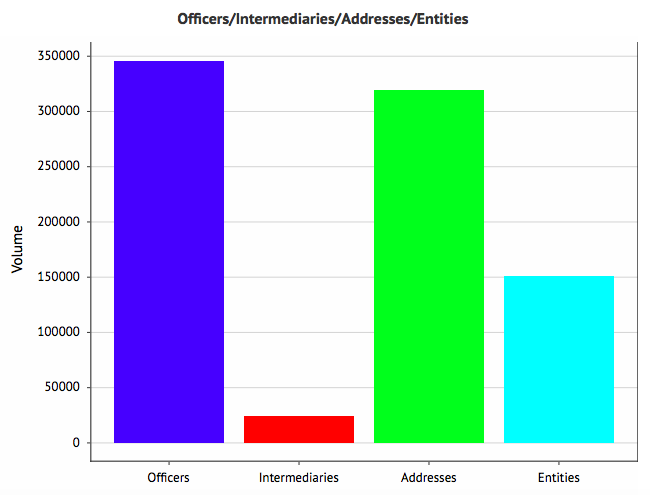

In [3]:
from IPython.display import Image
Image(filename='figs/oie.png')

In [4]:
all_nodes.head(100)

node_id address company_type    countries country_codes dorm_date  \
0   12000001     NaN          NaN  South Korea           KOR       NaN   
1   12000002     NaN          NaN        China           CHN       NaN   
2   12000003     NaN          NaN    Australia           AUS       NaN   
3   12000004     NaN          NaN        Japan           JPN       NaN   
4   12000005     NaN          NaN     Viet Nam           VNM       NaN   
5   12000006     NaN          NaN    Australia           AUS       NaN   
6   12000007     NaN          NaN  Philippines           PHL       NaN   
7   12000008     NaN          NaN       Taiwan           TWN       NaN   
8   12000009     NaN          NaN       Taiwan           TWN       NaN   
9   12000010     NaN          NaN        China           CHN       NaN   
10  12000011     NaN          NaN        China           CHN       NaN   
11  12000012     NaN          NaN          NaN           NaN       NaN   
12  12000013     NaN          NaN          NaN           NaN       NaN   
13  12000014     NaN          NaN          NaN           NaN       NaN   
14  12000015     NaN          NaN          NaN           NaN       NaN   
15  12000016     NaN          NaN          NaN           NaN       NaN   
16  12000017     NaN          NaN          NaN           NaN       NaN   
17  12000018     NaN          NaN          NaN           NaN       NaN   
18  12000019     NaN          NaN          NaN           NaN       NaN   
19  12000020     NaN          NaN          NaN           NaN       NaN   
20  12000021     NaN          NaN          NaN           NaN       NaN   
21  12000022     NaN          NaN          NaN           NaN       NaN   
22  12000023     NaN          NaN          NaN           NaN       NaN   
23  12000024     NaN          NaN       Monaco           MCO       NaN   
24  12000025     NaN          NaN       Monaco           MCO       NaN   
25  12000026     NaN          NaN        China           CHN       NaN   
26  12000027     NaN          NaN       Belize           BLZ       NaN   
27  12000028     NaN          NaN    Singapore           SGP       NaN   
28  12000029     NaN          NaN      Bahamas           BHS       NaN   
29  12000030     NaN          NaN        China           CHN       NaN   
..       ...     ...          ...          ...           ...       ...   
70  12000069     NaN          NaN          NaN           NaN       NaN   
71  12000070     NaN          NaN          NaN           NaN       NaN   
72  12000071     NaN          NaN          NaN           NaN       NaN   
73  12000072     NaN          NaN          NaN           NaN       NaN   
74  12000073     NaN          NaN          NaN           NaN       NaN   
75  12000074     NaN          NaN          NaN           NaN       NaN   
76  12000075     NaN          NaN          NaN           NaN       NaN   
77  12000076     NaN          NaN          NaN           NaN       NaN   
78  12000077     NaN          NaN          NaN           NaN       NaN   
79  12000078     NaN          NaN          NaN           NaN       NaN   
80  12000080     NaN          NaN          NaN           NaN       NaN   
81  12000081     NaN          NaN          NaN           NaN       NaN   
82  12000082     NaN          NaN          NaN           NaN       NaN   
83  12000083     NaN          NaN          NaN           NaN       NaN   
84  12000084     NaN          NaN          NaN           NaN       NaN   
85  12000085     NaN          NaN          NaN           NaN       NaN   
86  12000086     NaN          NaN          NaN           NaN       NaN   
87  12000087     NaN          NaN          NaN           NaN       NaN   
88  12000088     NaN          NaN          NaN           NaN       NaN   
89  12000089     NaN          NaN          NaN           NaN       NaN   
90  12000090     NaN          NaN          NaN           NaN       NaN   
91  12000091     NaN          NaN          NaN           NaN       NaN   
92  12000

## 2. Countries in *Panama Papers*

In [5]:
cc_dict=all_nodes[['country_codes','countries','node_id','type']].to_dict()
from collections import Counter
mono={}#Counter()
countries_dict={}
for k,v in cc_dict['country_codes'].items():
    if isinstance(v,float):
        continue
    vv=v.split(';')
    kk=cc_dict['countries'][k].split(';')
    for ik,vk in enumerate(vv):
        if vk not in mono:
            mono[vk]={}
        if cc_dict['type'][k] not in mono[vk]:
            mono[vk][cc_dict['type'][k]]=Counter()
        mono[vk][cc_dict['type'][k]][vk]+=1
        countries_dict[kk[ik]]=vk   
print 'The total number of countries in Panama Papers is', len(countries_dict)
key_lis=[]
for key in  sorted(countries_dict):
    vv=countries_dict[key]
    sor={'Country_name':key,'Country_code':vv}
    for k,v in mono[vv].items():
        sor[k]=v[vv] 
    key_lis.append(sor)#{'Country_name':key,'Country_code':vv,'Number_of_nodes':mono[countries_dict[key]]})
countries_pd=pd.DataFrame(key_lis)

The total number of countries in Panama Papers is 209


In [6]:
countries_pd

Country_code              Country_name  address  entity  intermediary  \
0            ALB                   Albania       23       2           NaN   
1            DZA                   Algeria       20     NaN           NaN   
2            ASM            American Samoa       10       1           NaN   
3            AND                   Andorra       41     490            22   
4            AGO                    Angola       39      10             1   
5            AIA                  Anguilla      115      23             1   
6            ATG       Antigua and Barbuda       39     280             8   
7            ARG                 Argentina      773     270            94   
8            ARM                   Armenia       32     NaN           NaN   
9            ABW                     Aruba       18      27             5   
10           AUS                 Australia     1408     118           201   
11           AUT                   Austria      115      76            23   
12           AZE                Azerbaijan      111       8             1   
13           BHS                   Bahamas      954    5021           122   
14           BHR                   Bahrain       68      13            12   
15           BGD                Bangladesh       42       2             3   
16           BRB                  Barbados       57      35            14   
17           BLR                   Belarus       87      35             4   
18           BEL                   Belgium      293      61            54   
19           BLZ                    Belize      274    1455            11   
20           BEN                     Benin        8     NaN           NaN   
21           BMU                   Bermuda      218     149            29   
22           BTN                    Bhutan        1     NaN           NaN   
23           BOL                   Bolivia       35      95            20   
24           BIH    Bosnia and Herzegovina        5     NaN           NaN   
25           BWA                  Botswana       82       6             2   
26           BRA                    Brazil     1438    1399           406   
27           VGB    British Virgin Islands     4125   69092            88   
28           BRN                    Brunei       60       5             9   
29           BGR                  Bulgaria      102      50             8   
..           ...                       ...      ...     ...           ...   
179          SUR                  Suriname        7     NaN           NaN   
180          SWZ                 Swaziland       19     NaN           NaN   
181          SWE                    Sweden      193      84            34   
182          CHE               Switzerland     3208   38077          1339   
183          SYR                     Syria       41       5             5   
184          TWN                    Taiwan    14610    2906          1324   
185          TJK                Tajikistan       12     NaN           NaN   
186          TZA                  Tanzania       38       3             3   
187          THA                  Thailand     1285    1013           362   
188          TGO                      Togo        3     NaN           NaN   
189          TON                     Tonga        2     NaN           NaN   
190          TTO       Trinidad and Tobago       15       6             4   
191          TUN                   Tunisia       26       4             3   
192          TUR                    Turkey      559     101            21   
193          TKM              Turkmenistan       16     NaN           NaN   
194          TCA  Turks and Caicos Islands       53      41            11   
195          VIR       U.S. Virgin Islands       69      13             8   
196          UGA                    Uganda        8       1             1   
197          UKR                   Ukraine      558     469            20   
198          ARE      United Arab Emirates     2081    7772           182   


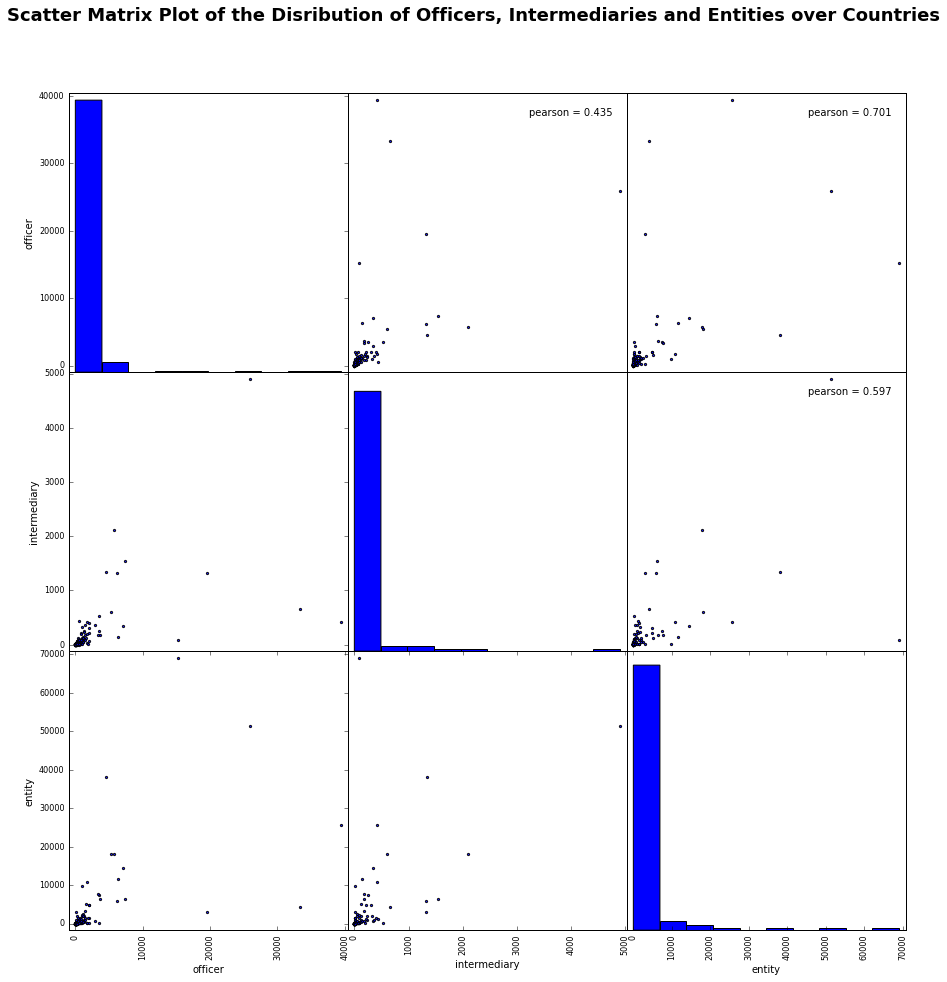

In [7]:
import warnings
warnings.filterwarnings("ignore")
ntei='Scatter Matrix Plot of the Disribution of Officers, Intermediaries and Entities over Countries' 
f, ax = plt.subplots(figsize=(15,15))
sss=scatter_matrix(countries_pd[['officer','intermediary','entity']], alpha=0.9, color='black', diagonal='hist',ax=ax)
plt.suptitle(ntei,fontsize=18,fontweight='bold')
corr = countries_pd.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sss, k=1)):
    sss[i, j].annotate("pearson = %.3f" %corr[i,j], (0.8, 0.93), xycoords='axes fraction', ha='center', va='center')

In [8]:
c1='Greece'
i1=70
c2='Cyprus'
i2=46
c3='Russia'
i3=154
c4='Turkey'
i4=192
c5='United Kingdom'
i5=199
c6='United States'
i6=200
c7='Belgium'
i7=18
c8='Austria'
i8=11
c9='Bulgaria'
i9=29
c10='Belarus'
i10=17
c11='Czech Republic'
i11=47
c12='Denmark'
i12=50
c13='Estonia'
i13=58
c14='Finland'
i14=61
c15='France'
i15=62
c16='Georgia'
i16=66
c17='Germany'
i17=67
c18='Hungary'
i18=81
c19='Iceland'
i19=82
c20='Italy'
i20=90
c21='Ireland'
i21=87
# c22='Kazakshtan'
# i22=95
c23='Latvia'
i23=100
c24='Liechtenstein'
i24=105
c25='Luxembourg'
i25=107
c26='Malta'
i26=115
c27='Moldova'
i27=120
c28='Monaco'
i28=121
c29='Netherlands'
i29=130
c30='Norway'
i30=139
c31='Ireland'
i31=87
c32='Poland'
i32=149
c33='Portugal'
i33=150
c34='Romania'
i34=153
c35='Serbia'
i35=165
c36='Slovakia'
i36=170
c37='Slovenia'
i37=171
c38='Spain'
i38=176
c39='Sweden'
i39=181
c40='Switzerland'
i40=182
c41='Ukraine'
i41=197
c42='Andorra'
i42=3
# c43='Azerbaijan'
# i43=12

# c1='Zimbabwe'
# i1=208
# c2='Turkey'
# i2=192
# c3='Venezuela'
# i3=204


gr=countries_pd[countries_pd['Country_name']==c1].to_dict()
negr=[]
negr.append(gr['officer'][i1])
negr.append(gr['intermediary'][i1])
negr.append(gr['entity'][i1])

cy=countries_pd[countries_pd['Country_name']==c2].to_dict()
necy=[]
necy.append(cy['officer'][i2])
necy.append(cy['intermediary'][i2])
necy.append(cy['entity'][i2])

ru=countries_pd[countries_pd['Country_name']==c3].to_dict()
neru=[]
neru.append(ru['officer'][i3])
neru.append(ru['intermediary'][i3])
neru.append(ru['entity'][i3])


cc4=countries_pd[countries_pd['Country_name']==c4].to_dict()
ncc4=[]
ncc4.append(cc4['officer'][i4])
ncc4.append(cc4['intermediary'][i4])
ncc4.append(cc4['entity'][i4])

cc5=countries_pd[countries_pd['Country_name']==c5].to_dict()
ncc5=[]
ncc5.append(cc5['officer'][i5])
ncc5.append(cc5['intermediary'][i5])
ncc5.append(cc5['entity'][i5])

cc6=countries_pd[countries_pd['Country_name']==c6].to_dict()
ncc6=[]
ncc6.append(cc6['officer'][i6])
ncc6.append(cc6['intermediary'][i6])
ncc6.append(cc6['entity'][i6])

cc7=countries_pd[countries_pd['Country_name']==c7].to_dict()
ncc7=[]
ncc7.append(cc7['officer'][i7])
ncc7.append(cc7['intermediary'][i7])
ncc7.append(cc7['entity'][i7])

cc8=countries_pd[countries_pd['Country_name']==c8].to_dict()
ncc8=[]
ncc8.append(cc8['officer'][i8])
ncc8.append(cc8['intermediary'][i8])
ncc8.append(cc8['entity'][i8])

cc9=countries_pd[countries_pd['Country_name']==c9].to_dict()
ncc9=[]
ncc9.append(cc9['officer'][i9])
ncc9.append(cc9['intermediary'][i9])
ncc9.append(cc9['entity'][i9])

cc10=countries_pd[countries_pd['Country_name']==c10].to_dict()
ncc10=[]
ncc10.append(cc10['officer'][i10])
ncc10.append(cc10['intermediary'][i10])
ncc10.append(cc10['entity'][i10])

cc11=countries_pd[countries_pd['Country_name']==c11].to_dict()
ncc11=[]
ncc11.append(cc11['officer'][i11])
ncc11.append(cc11['intermediary'][i11])
ncc11.append(cc11['entity'][i11])

cc12=countries_pd[countries_pd['Country_name']==c12].to_dict()
ncc12=[]
ncc12.append(cc12['officer'][i12])
ncc12.append(cc12['intermediary'][i12])
ncc12.append(cc12['entity'][i12])

cc13=countries_pd[countries_pd['Country_name']==c13].to_dict()
ncc13=[]
ncc13.append(cc13['officer'][i13])
ncc13.append(cc13['intermediary'][i13])
ncc13.append(cc13['entity'][i13])

cc14=countries_pd[countries_pd['Country_name']==c14].to_dict()
ncc14=[]
ncc14.append(cc14['officer'][i14])
ncc14.append(cc14['intermediary'][i14])
ncc14.append(cc14['entity'][i14])

cc15=countries_pd[countries_pd['Country_name']==c15].to_dict()
ncc15=[]
ncc15.append(cc15['officer'][i15])
ncc15.append(cc15['intermediary'][i15])
ncc15.append(cc15['entity'][i15])

cc16=countries_pd[countries_pd['Country_name']==c16].to_dict()
ncc16=[]
ncc16.append(cc16['officer'][i16])
ncc16.append(cc16['intermediary'][i16])
ncc16.append(cc16['entity'][i16])

cc17=countries_pd[countries_pd['Country_name']==c17].to_dict()
ncc17=[]
ncc17.append(cc17['officer'][i17])
ncc17.append(cc17['intermediary'][i17])
ncc17.append(cc17['entity'][i17])

cc18=countries_pd[countries_pd['Country_name']==c18].to_dict()
ncc18=[]
ncc18.append(cc18['officer'][i18])
ncc18.append(cc18['intermediary'][i18])
ncc18.append(cc18['entity'][i18])

cc19=countries_pd[countries_pd['Country_name']==c19].to_dict()
ncc19=[]
ncc19.append(cc19['officer'][i19])
ncc19.append(cc19['intermediary'][i19])
ncc19.append(cc19['entity'][i19])

cc20=countries_pd[countries_pd['Country_name']==c20].to_dict()
ncc20=[]
ncc20.append(cc20['officer'][i20])
ncc20.append(cc20['intermediary'][i20])
ncc20.append(cc20['entity'][i20])

cc21=countries_pd[countries_pd['Country_name']==c21].to_dict()
ncc21=[]
ncc21.append(cc21['officer'][i21])
ncc21.append(cc21['intermediary'][i21])
ncc21.append(cc21['entity'][i21])

# cc22=countries_pd[countries_pd['Country_name']==c22].to_dict()
# ncc22=[]
# ncc22.append(cc22['officer'][i22])
# ncc22.append(cc22['intermediary'][i22])
# ncc22.append(cc22['entity'][i22])

cc23=countries_pd[countries_pd['Country_name']==c23].to_dict()
ncc23=[]
ncc23.append(cc23['officer'][i23])
ncc23.append(cc23['intermediary'][i23])
ncc23.append(cc23['entity'][i23])

cc24=countries_pd[countries_pd['Country_name']==c24].to_dict()
ncc24=[]
ncc24.append(cc24['officer'][i24])
ncc24.append(cc24['intermediary'][i24])
ncc24.append(cc24['entity'][i24])

cc25=countries_pd[countries_pd['Country_name']==c25].to_dict()
ncc25=[]
ncc25.append(cc25['officer'][i25])
ncc25.append(cc25['intermediary'][i25])
ncc25.append(cc25['entity'][i25])

cc26=countries_pd[countries_pd['Country_name']==c26].to_dict()
ncc26=[]
ncc26.append(cc26['officer'][i26])
ncc26.append(cc26['intermediary'][i26])
ncc26.append(cc26['entity'][i26])

cc27=countries_pd[countries_pd['Country_name']==c27].to_dict()
ncc27=[]
ncc27.append(cc27['officer'][i27])
ncc27.append(cc27['intermediary'][i27])
ncc27.append(cc27['entity'][i27])

cc28=countries_pd[countries_pd['Country_name']==c28].to_dict()
ncc28=[]
ncc28.append(cc28['officer'][i28])
ncc28.append(cc28['intermediary'][i28])
ncc28.append(cc28['entity'][i28])

cc29=countries_pd[countries_pd['Country_name']==c29].to_dict()
ncc29=[]
ncc29.append(cc29['officer'][i29])
ncc29.append(cc29['intermediary'][i29])
ncc29.append(cc29['entity'][i29])

cc30=countries_pd[countries_pd['Country_name']==c30].to_dict()
ncc30=[]
ncc30.append(cc30['officer'][i30])
ncc30.append(cc30['intermediary'][i30])
ncc30.append(cc30['entity'][i30])

cc31=countries_pd[countries_pd['Country_name']==c31].to_dict()
ncc31=[]
ncc31.append(cc31['officer'][i31])
ncc31.append(cc31['intermediary'][i31])
ncc31.append(cc31['entity'][i31])

cc32=countries_pd[countries_pd['Country_name']==c32].to_dict()
ncc32=[]
ncc32.append(cc32['officer'][i32])
ncc32.append(cc32['intermediary'][i32])
ncc32.append(cc32['entity'][i32])

cc33=countries_pd[countries_pd['Country_name']==c33].to_dict()
ncc33=[]
ncc33.append(cc33['officer'][i33])
ncc33.append(cc33['intermediary'][i33])
ncc33.append(cc33['entity'][i33])

cc34=countries_pd[countries_pd['Country_name']==c34].to_dict()
ncc34=[]
ncc34.append(cc34['officer'][i34])
ncc34.append(cc34['intermediary'][i34])
ncc34.append(cc34['entity'][i34])

cc35=countries_pd[countries_pd['Country_name']==c35].to_dict()
ncc35=[]
ncc35.append(cc35['officer'][i35])
ncc35.append(cc35['intermediary'][i35])
ncc35.append(cc35['entity'][i35])

cc36=countries_pd[countries_pd['Country_name']==c36].to_dict()
ncc36=[]
ncc36.append(cc36['officer'][i36])
ncc36.append(cc36['intermediary'][i36])
ncc36.append(cc36['entity'][i36])

cc37=countries_pd[countries_pd['Country_name']==c37].to_dict()
ncc37=[]
ncc37.append(cc37['officer'][i37])
ncc37.append(cc37['intermediary'][i37])
ncc37.append(cc37['entity'][i37])

cc38=countries_pd[countries_pd['Country_name']==c38].to_dict()
ncc38=[]
ncc38.append(cc38['officer'][i38])
ncc38.append(cc38['intermediary'][i38])
ncc38.append(cc38['entity'][i38])

cc39=countries_pd[countries_pd['Country_name']==c39].to_dict()
ncc39=[]
ncc39.append(cc39['officer'][i39])
ncc39.append(cc39['intermediary'][i39])
ncc39.append(cc39['entity'][i39])

cc40=countries_pd[countries_pd['Country_name']==c40].to_dict()
ncc40=[]
ncc40.append(cc40['officer'][i40])
ncc40.append(cc40['intermediary'][i40])
ncc40.append(cc40['entity'][i40])

cc41=countries_pd[countries_pd['Country_name']==c41].to_dict()
ncc41=[]
ncc41.append(cc41['officer'][i41])
ncc41.append(cc41['intermediary'][i41])
ncc41.append(cc41['entity'][i41])

cc42=countries_pd[countries_pd['Country_name']==c42].to_dict()
ncc42=[]
ncc42.append(cc42['officer'][i42])
ncc42.append(cc42['intermediary'][i42])
ncc42.append(cc42['entity'][i42])

# cc43=countries_pd[countries_pd['Country_name']==c43].to_dict()
# ncc43=[]
# ncc43.append(cc43['officer'][i42])
# ncc43.append(cc43['intermediary'][i42])
# ncc43.append(cc43['entity'][i42])



lisl=[]
for i,v in enumerate(negr):
    if i ==0:
                lisl.append([v,necy[i],neru[i],ncc4[i],ncc5[i],ncc7[i],ncc8[i],ncc9[i],ncc10[i],ncc11[i],ncc12[i],ncc13[i],ncc14[i],ncc15[i],ncc16[i],ncc17[i],ncc18[i],ncc19[i],ncc20[1],ncc21[i],ncc23[i],ncc24[i],ncc25[i],ncc26[i],ncc27[i],ncc28[i],ncc29[i],ncc30[i],ncc31[i],ncc32[i],ncc33[i],ncc34[i],ncc35[i],ncc36[i],ncc37[1],ncc38[i],ncc39[i],ncc40[i],ncc41[i],ncc42[i],ncc6[i]]) #ncc22[i], ,ncc43[i]

    elif i==1:
        lisl.append([v+negr[i-1],necy[i]+necy[i-1],neru[i]+neru[i-1],ncc4[i]+ncc4[i-1],ncc5[i]+ncc5[i-1],ncc7[i]+ncc7[i-1],ncc8[i]+ncc8[i-1],ncc9[i]+ncc9[i-1],ncc10[i]+ncc10[i-1],ncc11[i]+ncc11[i-1],ncc12[i]+ncc12[i-1],ncc13[i]+ncc13[i-1],ncc14[i]+ncc14[i-1],ncc15[i]+ncc15[i-1],ncc16[i]+ncc16[i-1],ncc17[i]+ncc17[i-1],ncc18[i]+ncc18[i-1],ncc19[i]+ncc19[i-1],ncc20[i]+ncc20[i-1],ncc21[i]+ncc21[i-1],ncc23[i]+ncc23[i-1],ncc24[i]+ncc24[i-1],ncc25[i]+ncc25[i-1],ncc26[i]+ncc26[i-1],ncc27[i]+ncc27[i-1],ncc28[i]+ncc28[i-1],ncc29[i]+ncc29[i-1],ncc30[i]+ncc30[i-1],ncc31[i]+ncc31[i-1],ncc32[i]+ncc32[i-1],ncc33[i]+ncc33[i-1],ncc34[i]+ncc34[i-1],ncc35[i]+ncc35[i-1],ncc36[i]+ncc36[i-1],ncc37[i]+ncc37[i-1],ncc38[i]+ncc38[i-1],ncc39[i]+ncc39[i-1],ncc40[i]+ncc40[i-1],ncc41[i]+ncc41[i-1],ncc42[i]+ncc42[i-1],ncc6[i]+ncc6[i-1]
                    ]) #,ncc43[i]+ncc43[i-1] ncc22[i]+ncc22[i-1],
    elif i==2:
        lisl.append([v+negr[i-1]+negr[i-2],necy[i]+necy[i-1]+necy[i-2],neru[i]+neru[i-1]+neru[i-2],ncc4[i]+ncc4[i-1]+ncc4[i-2],ncc5[i]+ncc5[i-1]+ncc5[i-2],ncc7[i]+ncc7[i-1]+ncc7[i-2],ncc8[i]+ncc8[i-1]+ncc8[i-2],ncc9[i]+ncc9[i-1]+ncc9[i-2],ncc10[i]+ncc10[i-1]+ncc10[i-2],ncc11[i]+ncc11[i-1]+ncc11[i-2],ncc12[i]+ncc12[i-1]+ncc12[i-2],ncc13[i]+ncc13[i-1]+ncc13[i-2],ncc14[i]+ncc14[i-1]+ncc14[i-2],ncc15[i]+ncc15[i-1]+ncc15[i-2],ncc16[i]+ncc16[i-1]+ncc16[i-2],ncc17[i]+ncc17[i-1]+ncc17[i-2],ncc18[i]+ncc18[i-1]+ncc18[i-2],ncc19[i]+ncc19[i-1]+ncc19[i-2],ncc20[i]+ncc20[i-1]+ncc20[i-2],ncc21[i]+ncc21[i-1]+ncc21[i-2],ncc23[i]+ncc23[i-1]+ncc23[i-2],ncc24[i]+ncc24[i-1]+ncc24[i-2],ncc25[i]+ncc25[i-1]+ncc25[i-2],ncc26[i]+ncc26[i-1]+ncc26[i-2],ncc27[i]+ncc27[i-1]+ncc27[i-2],ncc28[i]+ncc28[i-1]+ncc28[i-2],ncc29[i]+ncc29[i-1]+ncc29[i-2],ncc30[i]+ncc30[i-1]+ncc30[i-2],ncc31[i]+ncc31[i-1]+ncc31[i-2],ncc32[i]+ncc32[i-1]+ncc32[i-2],ncc33[i]+ncc33[i-1]+ncc33[i-2],ncc34[i]+ncc34[i-1]+ncc34[i-2],ncc35[i]+ncc35[i-1]+ncc35[i-2],ncc36[i]+ncc36[i-1]+ncc36[i-2],ncc37[i]+ncc37[i-1]+ncc37[i-2],ncc38[i]+ncc38[i-1]+ncc38[i-2],ncc39[i]+ncc39[i-1]+ncc39[i-2],ncc40[i]+ncc40[i-1]+ncc40[i-2],ncc41[i]+ncc41[i-1]+ncc41[i-2],ncc42[i]+ncc42[i-1]+ncc42[i-2],ncc6[i]+ncc6[i-1]+ncc6[i-2]]) #,ncc43[i]+ncc43[i-1]+ncc43[i-2] ,ncc22[i]+ncc22[i-1]+ncc22[i-2]
# #     print lisl,i
# beaker.tot=lisl                             
# # beaker.negr=negr
# # beaker.necy=necy
# # beaker.neru=neru
# beaker.base=[0,lisl[0],lisl[1]]
# beaker.countries=[c1,c2,c3,c4,c5,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c23,c24,c25,c26,c27, c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,c40,c41,c42,c6] #c22,,c43

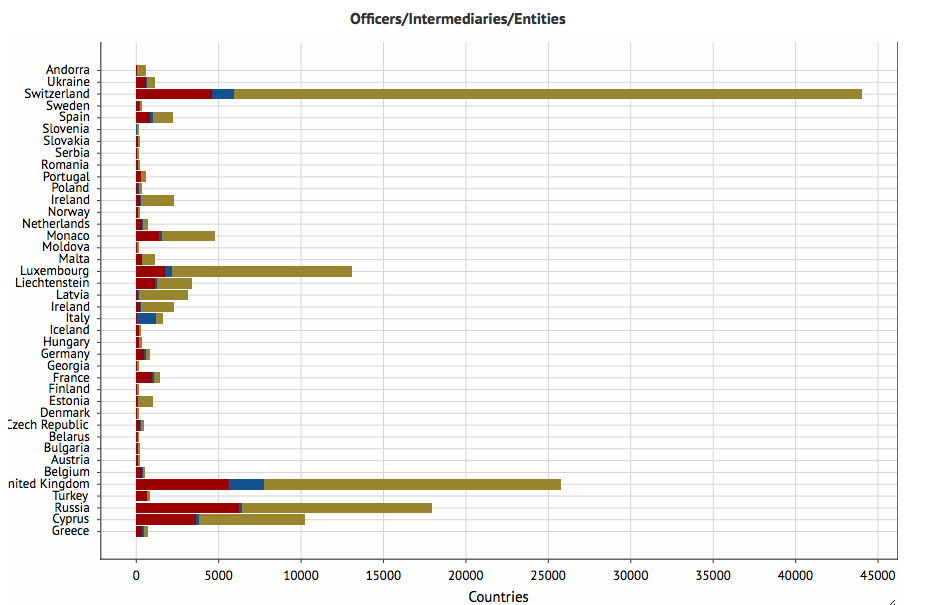

In [9]:
Image(filename='figs/coie.png')

## 3. THE TWO-MODE NETWORK OF GREEK-CYPRIOT-RUSSIAN OFFICERS & ENTITIES

In [10]:
name1 = c1 #Greece
cc1=countries_dict[name1]

c2='Cyprus'
name2=c2
cc2=countries_dict[name2]
# c2=''
# cc2={}
# name2=c2

c3='Russia'
name3=c3
cc3=countries_dict[name3]

names = ", ".join([c1,c2,c3])#'Russian Federarion, Greece and Cyprus'
# names

def find_nodes_countries(cc,cc_dict):
    cnodes_dict=[]    
    for k,v in cc_dict['country_codes'].items():
        if isinstance(v,float):
            continue
        vv=v.split(';')
        for ik,vk in enumerate(vv):
            if vk ==cc:
                cnodes_dict.append(cc_dict['node_id'][k])
    return cnodes_dict

ccnodes1=find_nodes_countries(cc1,cc_dict)
print 'Total number of nodes from %s: %i' %(name1,len(ccnodes1)) #,cc1
ccnodes2=find_nodes_countries(cc2,cc_dict)
print 'Total number of nodes from %s: %i' %(name2,len(ccnodes2)) #,cc1
# print 'Total number of nodes from', name2, ':', len(ccnodes2) #,cc2
ccnodes3=find_nodes_countries(cc3,cc_dict)
print 'Total number of nodes from %s: %i' %(name3,len(ccnodes3))
# print 'Total number of nodes from %s: %i' %(name1,len(ccnodes1)+len(ccnodes2)+len(ccnodes3))
# print 'Total number of nodes from all countries (%s, %s, %s): %i' %(name1,name2,name3, 
#                                                                          len(ccnodes1)+len(ccnodes2)+len(ccnodes3))

nodes_rem=[]
for k,v in alBear['status'].items():
    nodes_rem.append(k)
# fildirg='/home/sergios-len/Dropbox/Python Projects (1)/PPs'
# fildirg='/home/mosesboudourides/Dropbox/Python Projects/PPs'
# F1=nx.read_graphml(os.path.join(fildirg, 'graphs/F1.graphml')) 
F1=nx.read_graphml('graphs/F1.graphml') 
    
union_nodes=list(set(ccnodes1).union(set(ccnodes2)).union(set(ccnodes3)))#
union_nodes=[str(i) for i in union_nodes]
# ccnodes1
# print len(union_nodes)
F=F1
graph = nx.subgraph(F, union_nodes)
graph.remove_nodes_from(nx.isolates(graph))

offic = list(Officers['node_id'].unique())
inter = list(Intermediaries['node_id'].unique())
enti = list(Entities['node_id'].unique())
addr = list(Addresses['node_id'].unique())


# print 'Total number of nodes in the (%s,%s,%s) graph: %i' %(name1,name2,name3,len(graph.nodes()))

labels={}
groups={}
noddd={}
deg=nx.degree(graph)
ngroups={}
cgroups={}
for i,nd in enumerate(graph.nodes()):
    noddd[nd]=i
    nd=int(nd) 
    if nd in ccnodes1:
        groups[i]=1
    elif nd in ccnodes2:
        groups[i]=2
    elif nd in ccnodes3:
        groups[i]=3

    if nd in offic:
        labels[i]=Officers.loc[Officers['node_id'] == nd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=1
    elif nd in inter:
        labels[i]= Intermediaries.loc[Intermediaries['node_id'] == nd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=4
    elif nd in enti:
        labels[i]= Entities.loc[Entities['node_id'] == nd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=5

    elif nd in addr:
        labels[i]= Addresses.loc[Addresses['node_id'] == nd]['address'].tolist()[0]#.capitalize()
        ngroups[i]=2
        
colorr={} 
for k,v in ngroups.items():
    if v ==1:      # Officers
        if groups[k]==1:   #Greece
            colorr[k]=(204,204,255)
        elif groups[k]==2:  # Cyprus
            colorr[k]=(204,255,204)
        elif groups[k]==3:  #Russia
            colorr[k]= (255,204,204)
    elif v==5:
        if groups[k]==1:   #Greece
            colorr[k]=(0,0,255)
        elif groups[k]==2:  # Cyprus
            colorr[k]=(0,255,0)
        elif groups[k]==3:  #Russsia
            colorr[k]= (255,0,0)
    else:
        colorr[k]= (255,255,255)
lali=[]
grouli=[]
cols=[]
vals=[]
for  v in graph.nodes():
    lali.append(labels[noddd[v]])
    grouli.append(groups[noddd[v]])
    cols.append(colorr[noddd[v]])
    vals.append(deg[v])    
edges=[]
for edd in graph.edges():
    if 'weight' in graph[edd[0]][edd[1]]:
        wei=graph[edd[0]][edd[1]]['weight']
    else:
        wei=1
    edges.append([noddd[edd[0]],noddd[edd[1]],wei])   
print 'Total number of nonisolated nodes in the graph of %s, %s and %s: %i' %(name1,name2,name3,len(cols))
print 'Total number of edges in the graph of %s, %s and %s: %i' %(name1,name2,name3,len(edges))
# print 'Total number of edges in the (%s,%s,%s) graph: %i' %(name1,name2,name3,len(edges))
# 'Number of nodes: %i Number of edges: %i' %(len(cols),len(edges))

Total number of nodes from Greece: 1013
Total number of nodes from Cyprus: 12620
Total number of nodes from Russia: 23475
Total number of nonisolated nodes in the graph of Greece, Cyprus and Russia: 7817
Total number of edges in the graph of Greece, Cyprus and Russia: 5869



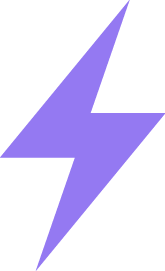

Running local mode, some functionality limited.



In [11]:
lgn = Lightning(ipython=True,local=True,size='large') # local vis
vis=lgn.force(conn=edges, values=None, labels=lali, color=cols, group=None, colormap=None, size=3, tooltips=True,
              width=1200, brush=True,zoom=True, height=None,
              description=r'''## **The Panama Papers Network of %s**''' %names)
vis # local vis

In [12]:
def get_nat(ed,c_d):
    natt=None
    for nat in c_d:
#         print nat,c_d[nat]
        if int(ed) in c_d[nat]:
            natt=nat
    return natt
            
def count_edges_nat(c_d,edges):
    nat_edgs=Counter()
    for ed in edges:
        edg=get_nat(ed[0],c_d)
        deg=get_nat(ed[1],c_d)
        edd=sorted((edg,deg))
        edde='%s , %s' %(edd[0],edd[1])
#         print ed,edg,deg,sorted(edg,deg)
        nat_edgs[edde]+=1
    return nat_edgs
c_d={c1:ccnodes1,c2:ccnodes2,c3:ccnodes3}
edges_nationalities=count_edges_nat(c_d,graph.edges())
for nat,nat_value in edges_nationalities.items():
    natt=nat.split(' ,')
    print 'There are %i edges between %s and %s' %(nat_value,natt[0],natt[1])

een=edges_nationalities.values()
r1 = [2*een[4],een[-1],een[1]]
r2 = [een[-1],2*een[3],een[2]]
r3 = [een[1],een[2],2*een[0]]
m=[r1,r2,r3]
import numpy as np
M=np.array(m)
if M.sum() != 1.0:
    M=M/float(M.sum())
M=np.asmatrix(M)
s=(M*M).sum()
t=M.trace()
R=t-s
r=R/(1-s)
ac = float(r)
print 'The Attribute Assortativity Coefficient of the graph of %s, %s and %s is %.4f' %(name1,name2,name3,ac)

There are 2832 edges between Russia and  Russia
There are 6 edges between Greece and  Russia
There are 863 edges between Cyprus and  Russia
There are 2073 edges between Cyprus and  Cyprus
There are 27 edges between Greece and  Greece
There are 68 edges between Cyprus and  Greece
The Attribute Assortativity Coefficient of the graph of Greece, Cyprus and Russia is 0.6826


## 4. THE PROJECTED NETWORK OF GREEK-CYPRIOT-RUSSIAN OFFICERS

In [13]:
import itertools as it
addr=[str(i) for i in addr]
offic=[str(i) for i in offic]
enti=[str(i) for i in enti]
# nodes_no_addr_ent=set(union_nodes)-(set(addr).union(set(offic)))
nodes_no_addr_ent=set(union_nodes)-(set(addr).union(set(enti)))
# print len(union_nodes)
# print len(nodes_no_addr_ent)
pgraph = nx.subgraph(F, nodes_no_addr_ent)
# print len(enti),len(addr)
entil=set(enti).intersection(set(union_nodes))
addrl=set(addr).intersection(set(union_nodes))
# print len(entil),len(addrl)
ll=[enti] 
for ae in ll:
    for nd in ae:
        if nd in graph:
            nnei=nx.all_neighbors(graph,nd)
            nei=list(set(nodes_no_addr_ent).intersection(set(nnei)))
            for ii in it.combinations(nei,2):
                ed=ii[0]
                de=ii[1]
                if pgraph.has_edge(ed,de):
                    if 'weight' in pgraph[ed][de]:
                        wei=pgraph[ed][de]['weight']+1
                    else:
                        wei=1
                else:
                    wei=1
                pgraph.add_edge(ed,de,weight=wei)
pgraph.remove_nodes_from(nx.isolates(pgraph))
# print 'The projected network has', len(pgraph.nodes()), 'and', len(pgraph.edges()), 'edges'
print 'Total number of nonisolated nodes in the graph of %s, %s and %s: %i' %(name1,name2,name3,len(pgraph.nodes()))
print 'Total number of edges in the graph of %s, %s and %s: %i' %(name1,name2,name3,len(pgraph.edges()))

labels={}
groups={}
noddd={}
deg=nx.degree(pgraph)
ngroups={}
for i,nd in enumerate(pgraph.nodes()):
    noddd[nd]=i
    ndd=int(nd)
    if ndd in ccnodes1:
        groups[i]=1
    elif ndd in ccnodes2:
        groups[i]=2
    elif ndd in ccnodes3:
        groups[i]=3
    if nd in offic:
        labels[i]=Officers.loc[Officers['node_id'] == ndd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=1
    elif nd in inter:
        labels[i]= Intermediaries.loc[Intermediaries['node_id'] == ndd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=4
    elif nd in enti:
        labels[i]= Entities.loc[Entities['node_id'] == ndd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=5
    elif nd in addr:
        labels[i]= Addresses.loc[Addresses['node_id'] == ndd]['address'].tolist()[0]#.capitalize()
        ngroups[i]=2
# print groups

for k,v in ngroups.items():
    if v ==1:      # Officers
        if groups[k]==1:   #Greek
            colorr[k]=(204,204,255)
#             colorr[k]= (255,204,204)
        elif groups[k]==2:  # Cypr
            colorr[k]=(204,255,204)
        elif groups[k]==3:  #Rus
            colorr[k]= (255,204,204)
#             colorr[k]=(204,204,255)
    elif v==5:
        if groups[k]==1:   #Greek
            colorr[k]=(0,0,255)
#             colorr[k]= (255,0,0)
        elif groups[k]==2:  # Cypr
            colorr[k]=(0,255,0)
        elif groups[k]==3:  #Rus
            colorr[k]= (255,0,0)
    else:
        colorr[k]= (255,255,255)
plali=[]
pgrouli=[]
pcols=[]
pvals=[]
for v in pgraph.nodes():
    plali.append(labels[noddd[v]])
    pgrouli.append(groups[noddd[v]])
    pcols.append(colorr[noddd[v]])
    pvals.append(deg[v])   
pedges=[]
for edd in pgraph.edges():
    if 'weight' in pgraph[edd[0]][edd[1]]:
        wei=4*pgraph[edd[0]][edd[1]]['weight']
    else:
        wei=4
    pedges.append([noddd[edd[0]],noddd[edd[1]],wei])   
# print 'Number of nodes: %i Number of edges: %i' %(len(cols),len(edges))

ssssi=set()
for edd in pgraph.edges():
    if 'weight' in pgraph[edd[0]][edd[1]]:
        ssssi.add(pgraph[edd[0]][edd[1]]['weight'])
# print ssssi

Total number of nonisolated nodes in the graph of Greece, Cyprus and Russia: 3145
Total number of edges in the graph of Greece, Cyprus and Russia: 4821



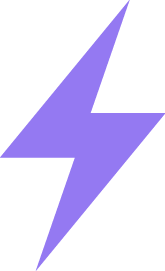

Running local mode, some functionality limited.



In [14]:
lgn = Lightning(ipython=True,local=True,size='large') #local
vis=lgn.force(conn=pedges, values=None, labels=plali, color=pcols, group=None, colormap=None, size=3, tooltips=True,
              width=1200, brush=True,zoom=True, height=800,
              description=r'''## **The Projected Panama Papers Network of %s**''' %names)
vis ## local

In [15]:
def get_nat(ed,c_d):
    natt=None
    for nat in c_d:
#         print nat,c_d[nat]
        if int(ed) in c_d[nat]:
            natt=nat
    return natt
            
def count_edges_nat(c_d,edges):
    nat_edgs=Counter()
    for ed in edges:
        edg=get_nat(ed[0],c_d)
        deg=get_nat(ed[1],c_d)
        edd=sorted((edg,deg))
        edde='%s , %s' %(edd[0],edd[1])
#         print ed,edg,deg,sorted(edg,deg)
        nat_edgs[edde]+=1
    return nat_edgs
c_d={c1:ccnodes1,c2:ccnodes2,c3:ccnodes3}
edges_nationalities=count_edges_nat(c_d,pgraph.edges())
for nat,nat_value in edges_nationalities.items():
    natt=nat.split(' ,')
    print 'There are %i edges between %s and %s' %(nat_value,natt[0],natt[1])
    
een=edges_nationalities.values()
r1 = [2*een[4],een[-1],een[1]]
r2 = [een[-1],2*een[3],een[2]]
r3 = [een[1],een[2],2*een[0]]
m=[r1,r2,r3]
import numpy as np
M=np.array(m)
if M.sum() != 1.0:
    M=M/float(M.sum())
M=np.asmatrix(M)
s=(M*M).sum()
t=M.trace()
R=t-s
r=R/(1-s)
ac = float(r)
print 'The Attribute Assortativity Coefficient of the graph of %s, %s and %s is %.4f' %(name1,name2,name3,ac)

There are 3148 edges between Russia and  Russia
There are 3 edges between Greece and  Russia
There are 537 edges between Cyprus and  Russia
There are 1040 edges between Cyprus and  Cyprus
There are 74 edges between Greece and  Greece
There are 19 edges between Cyprus and  Greece
The Attribute Assortativity Coefficient of the graph of Greece, Cyprus and Russia is 0.7254


In [16]:
def create_centralities_list(G,maxiter=2000,pphi=5,centList=[]):
    if len(centList)==0:
        centList=['degree_centrality','closeness_centrality','betweenness_centrality',
    'eigenvector_centrality','katz_centrality','page_rank']
    cenLen=len(centList)
    valus={}
    # plt.figure(figsize=figsi)
    for uu,centr in enumerate(centList):
        if centr=='degree_centrality':
            cent=nx.degree_centrality(G)
            sstt='Degree Centralities'
            ssttt='degree centrality'
            valus[centr]=cent
        elif centr=='closeness_centrality':
            cent=nx.closeness_centrality(G)
            sstt='Closeness Centralities'
            ssttt='closeness centrality'
            valus[centr]=cent
        elif centr=='betweenness_centrality':
            cent=nx.betweenness_centrality(G)
            sstt='Betweenness Centralities'
            ssttt='betweenness centrality'
            valus[centr]=cent
        elif centr=='eigenvector_centrality':
            try:
                cent=nx.eigenvector_centrality(G,max_iter=maxiter)
                sstt='Eigenvector Centralities'
                ssttt='eigenvector centrality'
                valus[centr]=cent
            except:
                valus[centr]=None
                continue
        elif centr=='katz_centrality':
            phi = (1+math.sqrt(pphi))/2.0 # largest eigenvalue of adj matrix
            cent=nx.katz_centrality_numpy(G,1/phi-0.01)
            sstt='Katz Centralities'
            ssttt='Katz centrality'
            valus[centr]=cent
        elif centr=='page_rank':
            try:
                cent=nx.pagerank(G)
                sstt='PageRank'
                ssttt='pagerank'
                valus[centr]=cent
            except:
                valus[centr]=None
                continue
        print '%s done!!!' %sstt
    return valus
centList=['degree_centrality','closeness_centrality','betweenness_centrality',
    'eigenvector_centrality','katz_centrality','page_rank']
centrali=create_centralities_list(pgraph)

dfco=pd.DataFrame()
u=0
for k in centList:
    try:
        v=centrali[k].values()
    except:
        v=None
    dfco.insert(u,k,v)
    u+=1
dfco.insert(0,'Nodes',centrali[centrali.keys()[0]].keys())

Degree Centralities done!!!
Closeness Centralities done!!!
Betweenness Centralities done!!!
Eigenvector Centralities done!!!
Katz Centralities done!!!
PageRank done!!!


In [17]:
dfco

Nodes  degree_centrality  closeness_centrality  \
0     12144174           0.000318              0.000318   
1     13010743           0.000318              0.000318   
2        22466           0.001272              0.004049   
3     12137501           0.000954              0.001272   
4     12137500           0.000954              0.000954   
5     12137502           0.000636              0.001566   
6     13007675           0.000954              0.000636   
7     12211045           0.000636              0.000954   
8     12154121           0.001272              0.000636   
9        23447           0.000318              0.000318   
10    12140152           0.000954              0.000318   
11    12140153           0.000318              0.000954   
12    12171888           0.000318              0.000318   
13    12161023           0.000636              0.000318   
14       40998           0.000318              0.000636   
15       24717           0.000318              0.000318   
16       24716           0.003817              0.000318   
17    12137611           0.000318              0.003817   
18    12137613           0.000318              0.000318   
19       25063           0.000318              0.000318   
20    12118791           0.000318              0.000318   
21    12118790           0.000318              0.000318   
22    12170051           0.000636              0.000318   
23    12099861           0.002545              0.000636   
24    13006617           0.000318              0.002545   
25    12126479           0.000318              0.000318   
26    12197067           0.000954              0.000318   
27    13001933           0.000318              0.000954   
28       23848           0.000636              0.000424   
29       21461           0.000636              0.000318   
...        ...                ...                   ...   
3115  12172377           0.000954              0.000318   
3116     28527           0.000318              0.000954   
3117     29172           0.000636              0.000674   
3118  12024899           0.000318              0.000636   
3119     21380           0.000318              0.000636   
3120  12200537           0.000318              0.000318   
3121  12200538           0.000318              0.000318   
3122  12207968           0.000954              0.000318   
3123     23199           0.000636              0.001417   
3124     23196           0.000636              0.000636   
3125     23197           0.001272              0.000636   
3126     40408           0.000954              0.003348   
3127  12172583           0.000954              0.000954   
3128  12123225           0.000318              0.000954   
3129  12212837           0.000318              0.000318   
3130  12212836           0.000954              0.000318   
3131     24403           0.000318              0.000954   
3132  12123223           0.000318              0.000318   
3133  12213836           0.000318              0.000318   
3134  12212838           0.001590              0.001590   
3135     27751           0.000318              0.000318   
3136  12128840           0.002545              0.001431   
3137  12024328           0.000318              0.000318   
3138  12137720           0.003817              0.003840   
3139  12137723           0.000318              0.000318   
3140  12196642           0.000318              0.000318   
3141  13004991           0.000318              0.000318   
3142     25930           0.005407              0.007328   
3143     20056           0.000636              0.004661   
3144     25933           0.004771              0.007185   

      betweenness_centrality  eigenvector_centrality  katz_centrality  \
0               0.000000e+00            9.617461e-79        -0.005279   
1               0.000000e+00            9.617461e-79        -0.005279   
2               0.000000e+00            9.961874e-07         0.000433   
3               0.000000e+00            1.219158e-48      

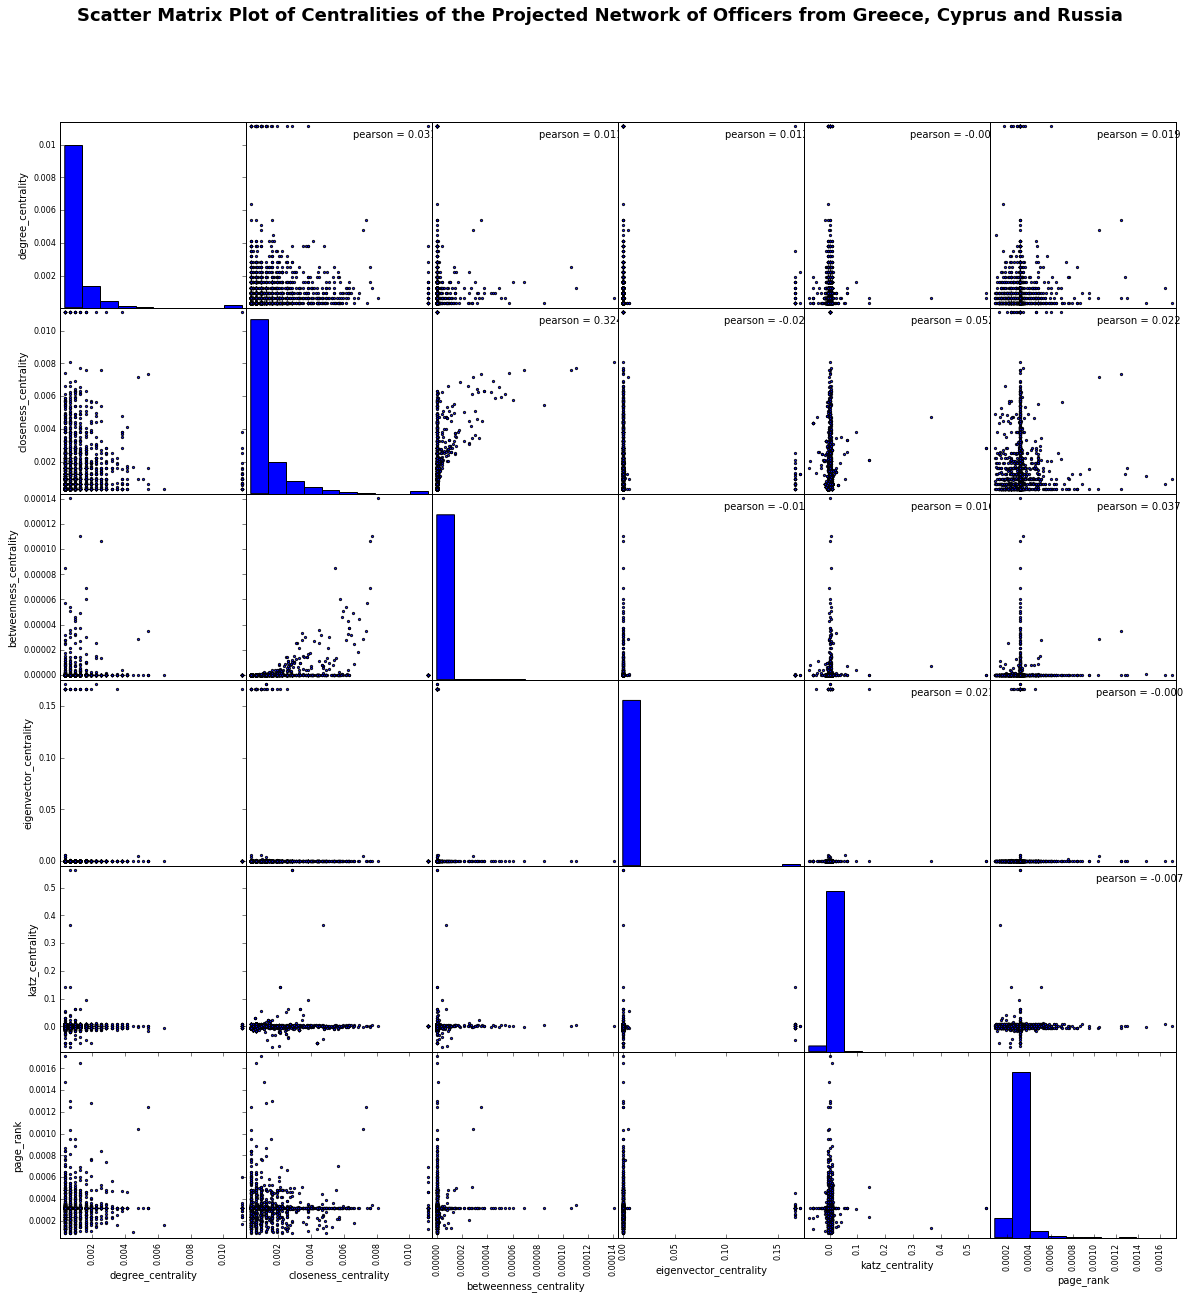

In [18]:
import warnings
warnings.filterwarnings("ignore")
ntei='Scatter Matrix Plot of Centralities of the Projected Network of Officers from %s, %s and %s' %(name1,name2,name3) #+ names
f, ax = plt.subplots(figsize=(20,20))
sss=scatter_matrix(dfco[centList], alpha=0.9, color='black', diagonal='hist',ax=ax)
plt.suptitle(ntei,fontsize=18,fontweight='bold')
corr = dfco.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sss, k=1)):
    sss[i, j].annotate("pearson = %.3f" %corr[i,j], (0.8, 0.93), xycoords='axes fraction', ha='center', va='center')

## 5. THE PROJECTED NETWORK OF GREEK-CYPRIOT-RUSSIAN ENTITIES

In [19]:
import itertools as it
addr=[str(i) for i in addr]
offic=[str(i) for i in offic]
enti=[str(i) for i in enti]
# nodes_no_addr_ent=set(union_nodes)-(set(addr).union(set(offic)))
nodes_no_addr_ent=set(union_nodes)-(set(addr).union(set(offic)))
# print len(union_nodes)
# print len(nodes_no_addr_ent)
pgraph = nx.subgraph(F, nodes_no_addr_ent)
# print len(enti),len(addr)
entil=set(enti).intersection(set(union_nodes))
addrl=set(addr).intersection(set(union_nodes))
# print len(entil),len(addrl)
ll=[offic] 
for ae in ll:
    for nd in ae:
        if nd in graph:
            nnei=nx.all_neighbors(graph,nd)
            nei=list(set(nodes_no_addr_ent).intersection(set(nnei)))
            for ii in it.combinations(nei,2):
                ed=ii[0]
                de=ii[1]
                if pgraph.has_edge(ed,de):
                    if 'weight' in pgraph[ed][de]:
                        wei=pgraph[ed][de]['weight']+1
                    else:
                        wei=1
                else:
                    wei=1
                pgraph.add_edge(ed,de,weight=wei)
pgraph.remove_nodes_from(nx.isolates(pgraph))
# print 'The projected network has', len(pgraph.nodes()), 'and', len(pgraph.edges()), 'edges'
print 'Total number of nonisolated nodes in the graph of %s, %s and %s: %i' %(name1,name2,name3,len(pgraph.nodes()))
print 'Total number of edges in the graph of %s, %s and %s: %i' %(name1,name2,name3,len(pgraph.edges()))

labels={}
groups={}
noddd={}
deg=nx.degree(pgraph)
ngroups={}
for i,nd in enumerate(pgraph.nodes()):
    noddd[nd]=i
    ndd=int(nd)
    if ndd in ccnodes1:
        groups[i]=1
    elif ndd in ccnodes2:
        groups[i]=2
    elif ndd in ccnodes3:
        groups[i]=3
    if nd in offic:
        labels[i]=Officers.loc[Officers['node_id'] == ndd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=1
    elif nd in inter:
        labels[i]= Intermediaries.loc[Intermediaries['node_id'] == ndd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=4
    elif nd in enti:
        labels[i]= Entities.loc[Entities['node_id'] == ndd]['name'].tolist()[0]#.capitalize()
        ngroups[i]=5
    elif nd in addr:
        labels[i]= Addresses.loc[Addresses['node_id'] == ndd]['address'].tolist()[0]#.capitalize()
        ngroups[i]=2
# print groups

for k,v in ngroups.items():
    if v ==1:      # Officers
        if groups[k]==1:   #Greek
            colorr[k]=(204,204,255)
#             colorr[k]= (255,204,204)
        elif groups[k]==2:  # Cypr
            colorr[k]=(204,255,204)
        elif groups[k]==3:  #Rus
            colorr[k]= (255,204,204)
#             colorr[k]=(204,204,255)
    elif v==5:
        if groups[k]==1:   #Greek
            colorr[k]=(0,0,255)
#             colorr[k]= (255,0,0)
        elif groups[k]==2:  # Cypr
            colorr[k]=(0,255,0)
        elif groups[k]==3:  #Rus
            colorr[k]= (255,0,0)
    else:
        colorr[k]= (255,255,255)
plali=[]
pgrouli=[]
pcols=[]
pvals=[]
for v in pgraph.nodes():
    plali.append(labels[noddd[v]])
    pgrouli.append(groups[noddd[v]])
    pcols.append(colorr[noddd[v]])
    pvals.append(deg[v])   
pedges=[]
for edd in pgraph.edges():
    if 'weight' in pgraph[edd[0]][edd[1]]:
        wei=4*pgraph[edd[0]][edd[1]]['weight']
    else:
        wei=4
    pedges.append([noddd[edd[0]],noddd[edd[1]],wei])   
# print 'Number of nodes: %i Number of edges: %i' %(len(cols),len(edges))

ssssi=set()
for edd in pgraph.edges():
    if 'weight' in pgraph[edd[0]][edd[1]]:
        ssssi.add(pgraph[edd[0]][edd[1]]['weight'])
# print ssssi

Total number of nonisolated nodes in the graph of Greece, Cyprus and Russia: 1526
Total number of edges in the graph of Greece, Cyprus and Russia: 4851



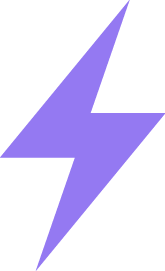

Running local mode, some functionality limited.



In [20]:
lgn = Lightning(ipython=True,local=True,size='large') #local
vis=lgn.force(conn=pedges, values=None, labels=plali, color=pcols, group=None, colormap=None, size=3, tooltips=True,
              width=1200, brush=True,zoom=True, height=800,
              description=r'''## **The Projected Panama Papers Network of %s**''' %names)
vis ## local

In [21]:
def get_nat(ed,c_d):
    natt=None
    for nat in c_d:
#         print nat,c_d[nat]
        if int(ed) in c_d[nat]:
            natt=nat
    return natt
            
def count_edges_nat(c_d,edges):
    nat_edgs=Counter()
    for ed in edges:
        edg=get_nat(ed[0],c_d)
        deg=get_nat(ed[1],c_d)
        edd=sorted((edg,deg))
        edde='%s , %s' %(edd[0],edd[1])
#         print ed,edg,deg,sorted(edg,deg)
        nat_edgs[edde]+=1
    return nat_edgs
c_d={c1:ccnodes1,c2:ccnodes2,c3:ccnodes3}
edges_nationalities=count_edges_nat(c_d,pgraph.edges())
for nat,nat_value in edges_nationalities.items():
    natt=nat.split(' ,')
    print 'There are %i edges between %s and %s' %(nat_value,natt[0],natt[1])
    
een=edges_nationalities.values()
# print een
# print aaaa
r1 = [2*een[1],0,0]
r2 = [0,2*een[-1],een[2]]
r3 = [0,een[2],2*een[0]]
# r1 = [2*een[4],een[-1],een[1]]
# r2 = [een[-1],2*een[3],een[2]]
# r3 = [een[1],een[2],2*een[0]]
m=[r1,r2,r3]
import numpy as np
M=np.array(m)
if M.sum() != 1.0:
    M=M/float(M.sum())
M=np.asmatrix(M)
s=(M*M).sum()
t=M.trace()
R=t-s
r=R/(1-s)
ac = float(r)
print 'The Attribute Assortativity Coefficient of the graph of %s, %s and %s is %.4f' %(name1,name2,name3,ac)

There are 1350 edges between Russia and  Russia
There are 1 edges between Greece and  Greece
There are 325 edges between Cyprus and  Russia
There are 3175 edges between Cyprus and  Cyprus
The Attribute Assortativity Coefficient of the graph of Greece, Cyprus and Russia is 0.8440


In [22]:
centList=['degree_centrality','closeness_centrality','betweenness_centrality',
    'eigenvector_centrality','katz_centrality','page_rank']
centrali=create_centralities_list(pgraph)
# centrali=create_centralities_list(graph_no_addr_ent)
dfce=pd.DataFrame()
u=0
for k in centList:
    try:
        v=centrali[k].values()
    except:
        v=None
    dfce.insert(u,k,v)
    u+=1
dfce.insert(0,'Nodes',centrali[centrali.keys()[0]].keys())

Degree Centralities done!!!
Closeness Centralities done!!!
Betweenness Centralities done!!!
Eigenvector Centralities done!!!
Katz Centralities done!!!
PageRank done!!!


In [23]:
dfce

Nodes  degree_centrality  closeness_centrality  \
0       228055           0.000656              0.012502   
1       228051           0.001311              0.002049   
2       220090           0.004590              0.004663   
3       230731           0.003934              0.003934   
4       230737           0.004590              0.004590   
5       214781           0.001311              0.001311   
6       201729           0.002623              0.002623   
7     10185432           0.001967              0.001967   
8       214894           0.009836              0.010710   
9     10122014           0.001311              0.001311   
10    10147320           0.000656              0.000874   
11      202299           0.005246              0.002951   
12      202351           0.000656              0.021486   
13    10126531           0.000656              0.000656   
14      205286           0.001311              0.001311   
15      205289           0.003934              0.003934   
16    10134051           0.000656              0.000656   
17    10139568           0.000656              0.000656   
18      230930           0.011148              0.011148   
19      227521           0.001311              0.001311   
20    10097787           0.000656              0.000656   
21      215419           0.001967              0.001967   
22      231217           0.015082              0.020175   
23      205739           0.015082              0.016066   
24      191469           0.019016              0.025268   
25      231265           0.012459              0.022357   
26      227234           0.000656              0.000656   
27      201548           0.015082              0.020175   
28      227237           0.009836              0.015270   
29      227014           0.001311              0.001311   
...        ...                ...                   ...   
1496    202158           0.000656              0.001475   
1497  10149174           0.000656              0.001311   
1498    222323           0.001311              0.001475   
1499    232655           0.001311              0.011148   
1500    226480           0.001311              0.006947   
1501    232653           0.011148              0.011148   
1502    212221           0.002623              0.000656   
1503    222924           0.011148              0.017726   
1504    212705           0.009836              0.010432   
1505    190132           0.010492              0.002142   
1506    221216           0.001311              0.000656   
1507    226260           0.000656              0.002623   
1508    216256           0.002623              0.003279   
1509    216257           0.003279              0.002342   
1510    216254           0.001967              0.002732   
1511  10130992           0.002623              0.000656   
1512    208819           0.000656              0.011803   
1513  10140969           0.001311              0.001311   
1514    195699           0.001311              0.012049   
1515    189751           0.011803              0.010710   
1516  10019193           0.009836              0.001967   
1517    223973           0.001967              0.001311   
1518  10153834           0.001311              0.001967   
1519    208956           0.000656              0.000656   
1520  10150249           0.002623              0.002623   
1521    225661           0.003934              0.007344   
1522    207273           0.006557              0.014872   
1523    225663           0.000656              0.002472   
1524  10099507           0.000656              0.000656   
1525    208958           0.001311              0.001311   

      betweenness_centrality  eigenvector_centrality  katz_centrality  \
0                   0.000000            6.376576e-05        -0.003156   
1                   0.000000            1.850154e-36         0.001355   
2                   0.000000            5.789683e-31        -0.000564   
3                   0.000000            3.413357e-21      

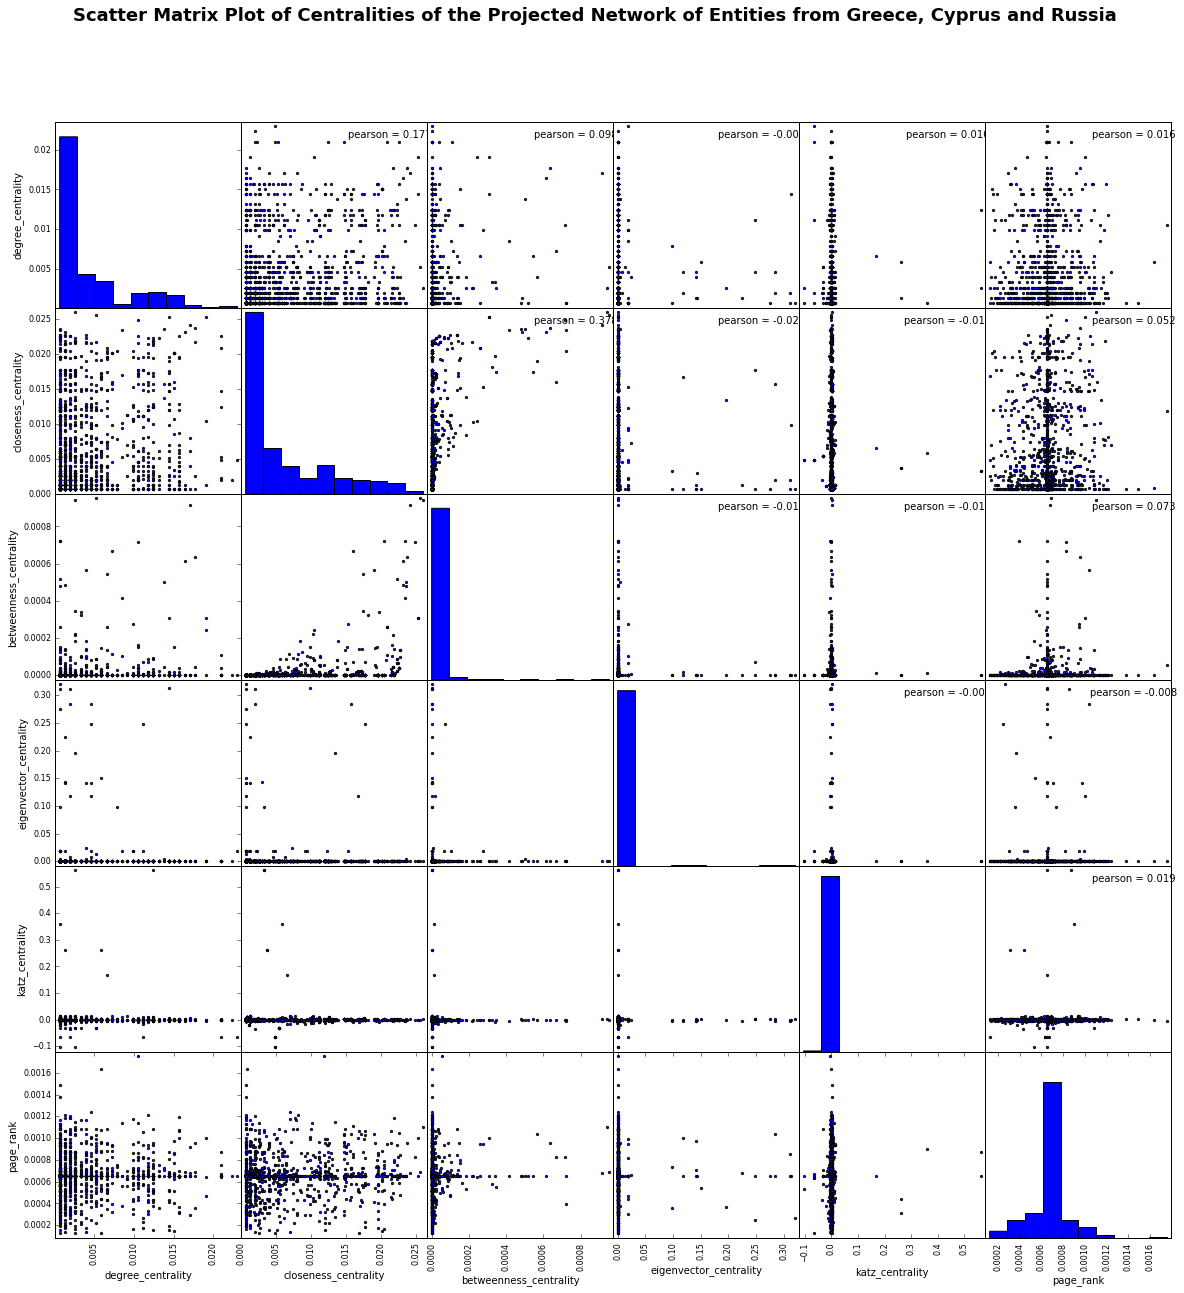

In [24]:
import warnings
warnings.filterwarnings("ignore")
ntei='Scatter Matrix Plot of Centralities of the Projected Network of Entities from %s, %s and %s' %(name1,name2,name3) #+ names
f, ax = plt.subplots(figsize=(20,20))
sss=scatter_matrix(dfce[centList], alpha=0.9, color='black', diagonal='hist',ax=ax)
plt.suptitle(ntei,fontsize=18,fontweight='bold')
corr = dfce.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sss, k=1)):
    sss[i, j].annotate("pearson = %.3f" %corr[i,j], (0.8, 0.93), xycoords='axes fraction', ha='center', va='center')

# sss= scatter_matrix(dfce[centList], alpha=0.9, figsize=(20,20), color='black', diagonal='hist')